In [1]:
print("ok")

ok


In [42]:
from pprint                    import pprint
import seaborn as sns
import pandas  as pd
%matplotlib inline

# Spark 2.0
from pyspark.sql               import SparkSession 

# Machine learning
from pyspark.ml                import Pipeline
from pyspark.ml.feature        import Bucketizer
from pyspark.ml.feature        import StringIndexer
from pyspark.ml.feature        import VectorAssembler
from pyspark.ml.evaluation     import MulticlassClassificationEvaluator
from pyspark.ml.evaluation     import BinaryClassificationEvaluator
from pyspark.ml.classification import RandomForestClassifier


from pyspark.sql               import functions as F
from pyspark.sql               import Window
from pyspark.sql.types         import FloatType
from pyspark.sql.functions     import udf
from pyspark.mllib.evaluation  import MulticlassMetrics

# 0) settings

In [3]:
app_name    = "classification_sexe_cycliste_avec_pipeline"
nb_cores    = 3
paralelisme = 3
memory      = 3
spark = SparkSession.builder\
.config("spark.app.name" , app_name )\
.config("spark.cores.max" , "%s"%(nb_cores) )\
.config("spark.default.parallelism", "%s"%(nb_cores*paralelisme) )\
.config("spark.storage.memoryFraction", "0.5" )\
.getOrCreate()


# 1) load data

In [4]:
url_fichier = "./../data/Villes/ville_1.csv"
data        = spark.read.option("header", "true").option("inferSchema", "true").csv(url_fichier)

In [5]:
data.count()

10499

# 2) jeu de test et d'apprentissage

In [6]:
(trainingData, testData) = data.randomSplit([0.7, 0.3])

# 3) transformation en objet spark

In [7]:
colonnes_explicatives = [ 'vitesse_a_pied','vitesse_a_velo', 'sportif', 'casseur', 
                         'statut-num', 'salaire', 'age', 'sportivite', 'velo_perf_minimale']

In [8]:
encode_statut     = StringIndexer(inputCol="statut" , outputCol="statut-num" )
encode_y          = StringIndexer(inputCol="sexe" , outputCol="label"      )
assemble_features = VectorAssembler(inputCols=colonnes_explicatives  , outputCol="features",  )

# 4) Création d'un pipeline de modification des données

In [9]:
algorithme = RandomForestClassifier()
etapes   = [encode_statut, encode_y, assemble_features, algorithme]


In [10]:
pipeline = Pipeline()
pipeline = pipeline.setStages(etapes)

# Test grid search

In [427]:
from pyspark.ml.tuning import CrossValidator
from pyspark.ml.tuning import ParamGridBuilder


# Définition de la grille des paramètres à chercher
paramGrid  = ParamGridBuilder()
paramGrid  = paramGrid.addGrid(algorithme.numTrees     , [1, 5, 10] )
paramGrid  = paramGrid.addGrid(algorithme.maxDepth     , [1, 5, 10] )
paramGrid  = paramGrid.build()

# Insertion de la grille dans un objet de cross-validation
# qui s'appuie sur le pipeline :

crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=4) 


cvModel = crossval.fit(trainingData)

# 5) modélisation du sexe par les colonnes explicatives

In [454]:
modele       = pipeline.fit(trainingData)


# 5 bis) choix de l'algorithme : soit modele, soit cvModel : 

In [657]:
predictions = cvModel.transform(testData)
predictions  = modele.transform(testData)

# 6) analyse des résultats : 
## 6.1) équilibre des classes

In [617]:
nb_de_lignes = predictions.count()
gp_par_label = predictions.groupBy("label").count()
gp_par_label.withColumn('percent', F.format_number((F.col('count') / nb_de_lignes) ,3) ).show()

+-----+-----+-------+
|label|count|percent|
+-----+-----+-------+
|  0.0| 1600|  0.496|
|  1.0| 1626|  0.504|
+-----+-----+-------+



## 6.2) matrice de confusion avec le seuil original de 0.5

In [618]:
tcd = predictions.groupBy("label").pivot("prediction").count()
tcd.show()

+-----+----+----+
|label| 0.0| 1.0|
+-----+----+----+
|  0.0|1595|   5|
|  1.0| 180|1446|
+-----+----+----+



In [619]:
tcd = tcd.withColumnRenamed("0.0", "label_0")
tcd = tcd.withColumnRenamed("1.0", "label_1")

In [620]:
tcd = tcd.withColumn('percent_0', F.format_number((F.col('label_0') / nb_de_lignes) ,3) )
tcd = tcd.withColumn('percent_1', F.format_number((F.col('label_1') / nb_de_lignes) ,3) )
tcd.show()

+-----+-------+-------+---------+---------+
|label|label_0|label_1|percent_0|percent_1|
+-----+-------+-------+---------+---------+
|  0.0|   1595|      5|    0.494|    0.002|
|  1.0|    180|   1446|    0.056|    0.448|
+-----+-------+-------+---------+---------+



In [621]:
rdd               = predictions.select("prediction", "label").rdd
metrics           = MulticlassMetrics(rdd)
rappel            = metrics.recall(0) # 0 est la valeur de la classe à tester de la classe
precision         = metrics.precision(0)

In [622]:
rappel, precision

(0.996875, 0.8985915492957747)

In [623]:
precision

0.8985915492957747

# 7) calcul des indicateurs pour chaque valeur de seuil

## 7.1) on va décomposer la prédiction

In [624]:
premier_element = udf(lambda v:float(v[0]),FloatType())
second_element  = udf(lambda v:float(v[1]),FloatType())

predictions = predictions.withColumn('proba_0', premier_element('probability').cast('double'))
predictions = predictions.withColumn('proba_1', second_element('probability').cast('double'))

## 7.2) on atribue une valeur de seuil arrondi à chaque probabilité 

In [625]:
# on veut 100 seuils différents
splits = [x/100 for x in range(0,101,1)]
# on instancie l'objet
bucketizer  = Bucketizer(splits=splits,inputCol="proba_0", outputCol="seuil_arrondi")
# on l'utilise pour rajouter une colonne à notre dataFrame de predictions
predictions = bucketizer.setHandleInvalid("keep").transform(predictions)

## 7.3) on calcule la somme cumulée des personnes adressées jusqu'à chaque seuil

In [626]:
# import de la fonction de fenêtrage
from pyspark.sql               import Window
# on tri par seuil_arrondi, puis on applique une somme sans limite
windowval   = Window.orderBy('seuil_arrondi').rangeBetween(Window.unboundedPreceding, 0)
# on applique cette fonction de fenêtrage sur un compte du nombre de ligne dans une colonne quelconque (on a pris seuil_arrondi mais on aurait pu prendre une autre colonne)
predictions = predictions.withColumn('nb_personne_cumule_jusqua_ce_seuil', F.count('seuil_arrondi').over(windowval))

## 7.4) pour chaque seuil on calcule les indicateurs : VP, FP, VN, FN, rappel, précision

In [627]:
r = []
for seuil in range(0, 100, 1):
    # création d'un nom de colonne pour la simulation de la classification
    print(seuil, end=",")
    seuil       = seuil/100
    new_col     = "seuil_%s"%seuil
    new_col     = new_col.replace(".", "_")
    
    # on crée une nouvelle colonne qui simule l'applicattion d'un seuil 
    # cette colonne est un booléen : sous le seuil, 0, au dessus, 1.
    predictions       = predictions.withColumn(new_col, F.col("proba_0") <= seuil)
    
    # on transforme les booléens en nombre pour pouvoir faire des calculs dessus:
    predictions       = predictions.withColumn(new_col, F.col(new_col).cast('double'))

    # Spark nous permet de calculer la précision et le recall à partir d'un objet
    # MulticlassMetrics, qui prend en paramètre une rdd : 
    rdd               = predictions.select(new_col, "label").rdd
    metrics           = MulticlassMetrics(rdd)
    rappel            = metrics.recall(0) # 0 est la valeur de la classe à tester de la classe
    precision         = metrics.precision(0)
    VP, FP, FN, VN = metrics.confusionMatrix().values
    
    # on enregistre les résultats dans un dictionnaire
    to_return   = { "seuil"                 : seuil,
                    "rappel"                : rappel, 
                    "precision"             : precision, 
                    "nb_VP"                 : VP     ,
                    "nb_FP"                 : FP     ,
                    "nb_FN"                 : FN     ,
                    "nb_VN"                 : VN    , }

    # on ajoute le dictionnaire à la liste des résultats
    r.append(to_return)

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,

# 8) analyse des résultats par seuil

## 8.1) passage à pandas

In [628]:
qualite_de_modele = pd.DataFrame(r)

## 8.2) précision / rappel par seuil

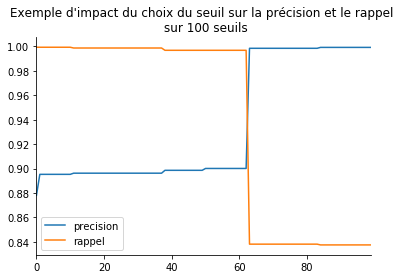

In [629]:
title = "Exemple d'impact du choix du seuil sur la précision et le rappel \n sur 100 seuils"
qualite_de_modele[["precision", "rappel"]].plot(title=title)
sns.despine()

# 8.3) affichage en mode heatmap

Text(0.5, 1.05, 'Performance du modèle selon la métrique de qualité \n et le choix du seuil de classification\n sur 3000 cas à prévoir')

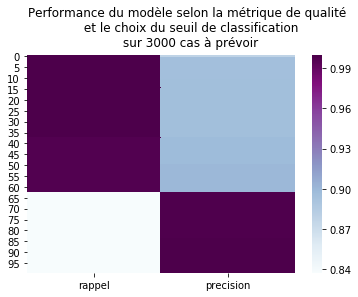

In [630]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
sns.heatmap(qualite_de_modele[["rappel", "precision"]],cmap="BuPu")
title="Performance du modèle selon la métrique de qualité \n et le choix du seuil de classification\n sur 3000 cas à prévoir"
y=1.05
plt.suptitle(t=title, y=y)

# 8.4) calcul de la rentabilité du ciblage

## 8.4.1) paramètres métiers

In [643]:
cout_ciblage  = 0
gain_d_un_VP  = 1000
gain_d_un_VN  = 0
cout_d_un_FP  = -10000
cout_d_un_FN  = 0


## 8.4.2) multiplication des paramètres par les ciblages

In [644]:
qualite_de_modele["gain_des_VP"] = qualite_de_modele["nb_VP"] * gain_d_un_VP
qualite_de_modele["gain_des_VN"] = qualite_de_modele["nb_VN"] * gain_d_un_VN

qualite_de_modele["cout_des_FP"] = qualite_de_modele["nb_FP"] * cout_d_un_FP
qualite_de_modele["cout_des_FN"] = qualite_de_modele["nb_FN"] * cout_d_un_FN


## 8.4.3) calcul de la rentabilité de la campagne : (on partirait logiquement sur les élèments ayant une plus forte probabilité, il faut donc compter un nombre de personne ciblé comme étant la somme des personnes ayant la plus grande probabilité d'abord)

In [645]:
qualite_de_modele["nb_de_cibles"] = qualite_de_modele[["nb_VP", "nb_FP"]].sum(axis=1)

# le cout de campagne est basé sur cette somme cumulative du nombre de personne ciblées
qualite_de_modele["cout_campagne"]          = qualite_de_modele["nb_de_cibles"]* cout_ciblage




# on peut maintenant calculer le ROI de la campagne pour chaque seuil : 
a_sommer = ["cout_campagne", 
            "gain_des_VP", 
            "cout_des_FP", 
            "cout_des_FN", 
            "gain_des_VN"]

qualite_de_modele["ROI_campagne"]= qualite_de_modele[a_sommer].sum(axis=1)

In [646]:
qualite_de_modele[35:40].T

,35,36,37,38,39
nb_FN,2.000000e+00,2.000000e+00,2.000000e+00,5.000000e+00,5.000000e+00
nb_FP,1.850000e+02,1.850000e+02,1.850000e+02,1.800000e+02,1.800000e+02
nb_VN,1.441000e+03,1.441000e+03,1.441000e+03,1.446000e+03,1.446000e+03
nb_VP,1.598000e+03,1.598000e+03,1.598000e+03,1.595000e+03,1.595000e+03
precision,8.962423e-01,8.962423e-01,8.962423e-01,8.985915e-01,8.985915e-01
rappel,9.987500e-01,9.987500e-01,9.987500e-01,9.968750e-01,9.968750e-01
seuil,3.500000e-01,3.600000e-01,3.700000e-01,3.800000e-01,3.900000e-01
gain_des_VP,1.598000e+06,1.598000e+06,1.598000e+06,1.595000e+06,1.595000e+06
gain_des_VN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
cout_des_FP,-1.850000e+06,-1.850000e+06,-1.850000e+06,-1.800000e+06,-1.800000e+06


In [647]:

# et trouver le ROI optimal : 
meilleur_ROI         = qualite_de_modele["ROI_campagne"].max()
filtre_sur_ROI       = qualite_de_modele.ROI_campagne == meilleur_ROI
meileur_choix        = qualite_de_modele[ filtre_sur_ROI]
# meilleur seuil : 
meilleur_seuil       = meileur_choix.seuil.values[0]
# nb de personnes à cibler : 
nb_de_personnes_ciblees = meileur_choix.nb_de_cibles.values[0]
nb_de_cible_atteinte    = meileur_choix.nb_VP.values[0]
nb_de_cible_ignorees    = meileur_choix.nb_FN.values[0]
gain_espere             = meileur_choix.ROI_campagne.values[0]
budget                  = meileur_choix.cout_campagne.values[0]

print("meilleur_seuil = ", meilleur_seuil)
print("meilleur_ROI = ", meilleur_ROI)
print("budget : ", budget)
print("nb de points de contacts = ", nb_de_personnes_ciblees)
print("nb de points de contacts convertis = ", nb_de_cible_atteinte)



meilleur_seuil =  0.84
meilleur_ROI =  1330000.0
budget :  0.0
nb de points de contacts =  1341.0
nb de points de contacts convertis =  1340.0


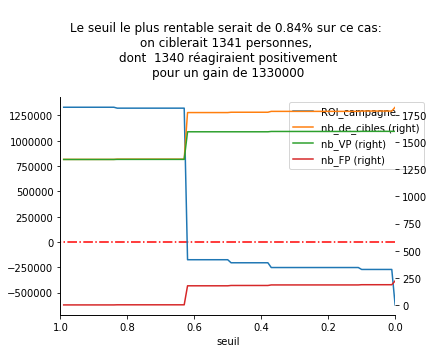

In [648]:
title = """
Le seuil le plus rentable serait de {meilleur_seuil}% sur ce cas: 
on ciblerait {nb_de_personnes_ciblees:.0f} personnes, 
dont  {nb_de_cible_atteinte:.0f} réagiraient positivement
pour un gain de {gain_espere:.0f}
""".format(**locals())


cols_ROI = [ "ROI_campagne", "seuil"]
cols_nb  = [ "nb_de_cibles", "nb_VP", "nb_FP" , "seuil"]
if True:
    ax   = qualite_de_modele[cols_ROI].plot(x="seuil")
    qualite_de_modele[cols_nb].plot(x="seuil", secondary_y=True, ax=ax)
else:
    ax = qualite_de_modele[cols_nb].plot(x="seuil")    
ax._axes.hlines(0, 0, 100, colors="red", linestyles="dashdot")
ax.get_legend().set_bbox_to_anchor((1.1, 1))
plt.title(title)
plt.xlim(1, 0)
sns.despine()


# 7) changer d'algorithme

In [680]:
url_fichier = "./../data/Villes/ville_1.csv"
data        = spark.read.option("header", "true").option("inferSchema", "true").csv(url_fichier)

In [691]:
data.select("id").drop_duplicates().count()

10499

In [676]:
path_cyclistes =  "./../data/Cyclistes/*"

In [677]:
cyclistes = spark.read.format("csv").option("header", "true").load(path_cyclistes)

In [664]:
path_poids_cyclistes = "./../data/Stations/*_poids_cyclistes.csv"
poids_des_cyclistes = spark.read.format("csv").option("header", "true").load(path_poids_cyclistes)

In [665]:
poids_des_cyclistes.count()

39432

In [685]:
poids_des_cyclistes.select("cycliste_id").drop_duplicates().count()

649

In [688]:
poids_des_cyclistes.select("cycliste_id").drop_duplicates().count()

649

In [687]:
poids_des_cyclistes.show(3)

+-------------------+----------+-----------+-----------------+
|          timestamp|station_id|cycliste_id|            poids|
+-------------------+----------+-----------+-----------------+
|2018-01-01 04:41:00|        50|        624|82.25627486605875|
|2018-01-01 07:27:00|        50|        812|            69.93|
|2018-01-01 07:38:00|        50|        676|69.20938186371659|
+-------------------+----------+-----------+-----------------+
only showing top 3 rows



In [669]:
un_poids_par_cycliste = poids_des_cyclistes.groupby("cycliste_id").agg(F.mean("poids"))

In [671]:
un_poids_par_cycliste.show(2)

+-----------+-----------------+
|cycliste_id|       avg(poids)|
+-----------+-----------------+
|        467|74.33819335120681|
|        829|88.61127243916386|
+-----------+-----------------+
only showing top 2 rows



In [672]:
predictions.count()

3226

In [674]:
predictions.join(un_poids_par_cycliste.withColumnRenamed("cycliste_id", "id"), on ="id", how=).count()

189

In [285]:
from pyspark.ml.classification import LogisticRegression

In [291]:
algorithme = LogisticRegression()
algorithme.setThreshold(0.1)
etapes   = [encode_statut, encode_y, assemble_features, algorithme]

In [292]:
pipeline = Pipeline()
pipeline = pipeline.setStages(etapes)

# 8) modélisation du sexe par les colonnes explicatives

In [293]:
modele       = pipeline.fit(trainingData)
predictions  = modele.transform(testData)

In [294]:
metriques = {
"f1"                 : MulticlassClassificationEvaluator()                     ,
"precision"          : MulticlassClassificationEvaluator(metricName="accuracy") ,
"precision ponderee" : MulticlassClassificationEvaluator(metricName="weightedPrecision") ,
"rappel pondere"     :  MulticlassClassificationEvaluator(metricName="weightedRecall")  ,    
"AUC"                :  BinaryClassificationEvaluator()                         }

for mesure, evaluator in metriques.items():
    valeur = evaluator.evaluate(predictions)
    print(valeur)
    print("{mesure: <18} : {valeur:.3f}".format(mesure=mesure, valeur=valeur))

1.0
f1                 : 1.000
1.0
precision          : 1.000
1.0
precision ponderee : 1.000
1.0
rappel pondere     : 1.000
1.0
AUC                : 1.000
